In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
plt.rcParams["figure.figsize"] = (10, 10)

# Monotonic transformation of a random variable

In [52]:
# X ~ N(0, 1)
from scipy.stats import norm
X = norm()
f_X = X.pdf

# Let y = 3 * x + 1
def _g(x):
    return 3 * x + 1
 
def _g_inv(y):
    return y / 3 - 1 / 3

# Derive f_Y from the inverse transform
x = T.dvector("x")
y = T.dvector("y")
g = theano.function([x], _g(x))
g_inv = theano.function([y], _g_inv(y))

_J, updates = theano.scan(lambda y_i: T.abs_(T.grad(_g_inv(y_i), y_i)), sequences=y)
J = theano.function([y], _J, updates=updates)

def f_Y(y):
    return J(y) * f_X(g_inv(y))

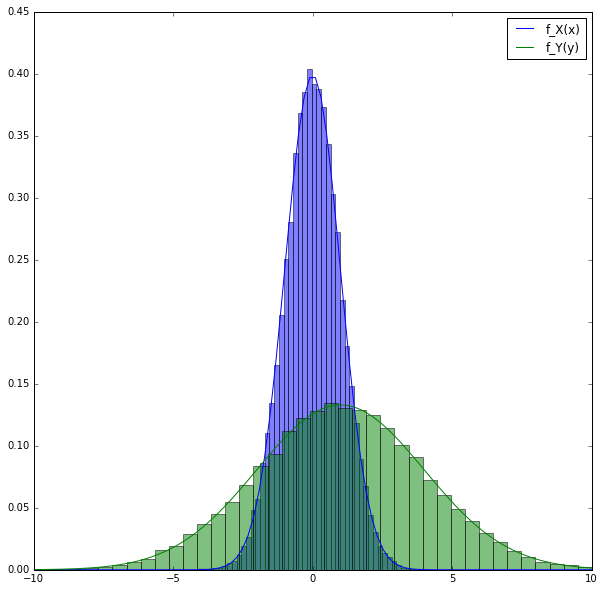

In [53]:
# Draw samples from X
samples = X.rvs(50000)

# Plot f_X
reals = np.linspace(-10, 10, num=100)
plt.hist(samples, normed=1, bins=50, alpha=0.5, color="b")
plt.plot(reals, f_X(reals), label="f_X(x)", color="b")

# Plot f_Y
plt.hist(g(samples), normed=1, bins=50, alpha=0.5, color="g")
plt.plot(reals, f_Y(reals), label="f_Y(y)", color="g")

plt.xlim(-10, 10)
plt.legend()
plt.show()

# Transformation in 2D

In [54]:
from scipy.stats import multivariate_normal
X =  multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1.5]])
f_X = X.pdf

def _polar_2d(coords):       
    r = T.sqrt(coords[:, 0] ** 2 + coords[:, 1] ** 2)
    phi = T.arctan2(coords[:, 1], coords[:, 0])
    return T.stack(r, phi).T
    
def _cartesian_2d(coords):    
    x = coords[:, 0] * T.cos(coords[:, 1])
    y = coords[:, 0] * T.sin(coords[:, 1])
    return T.stack(x, y).T

xy = T.dmatrix("xy")
rphi = T.dmatrix("rphi")
polar = theano.function([xy], _polar_2d(xy))
cartesian = theano.function([rphi], _cartesian_2d(rphi))

In [55]:
from theano.sandbox.linalg import det

def _cartesian_1d(coords):    
    x = coords[0] * T.cos(coords[1])
    y = coords[0] * T.sin(coords[1])
    return T.stack(x, y)

_J, updates = theano.scan(lambda rphi_i: T.abs_(det(T.jacobian(_cartesian_1d(rphi_i), rphi_i))), sequences=rphi)
J = theano.function([rphi], _J, updates=updates)

def f_Y(rphi):
    return J(rphi) * f_X(cartesian(rphi))    

[]

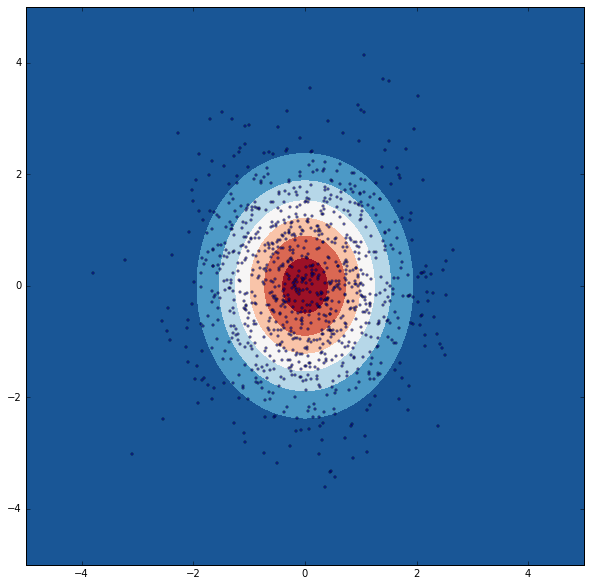

In [60]:
# Draw samples from X
samples = X.rvs(1000)

# Draw f_X for cartesian coordinates
mesh_xx, mesh_yy = np.meshgrid(np.linspace(-5, 5, 200), 
                               np.linspace(-5, 5, 200))
mesh = np.c_[mesh_xx.ravel(), mesh_yy.ravel()]

plt.figure()
plt.contourf(mesh_xx, mesh_yy, 
             f_X(mesh).reshape(mesh_xx.shape), 
             cmap=plt.cm.RdBu_r)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, marker=".")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.plot()

[]

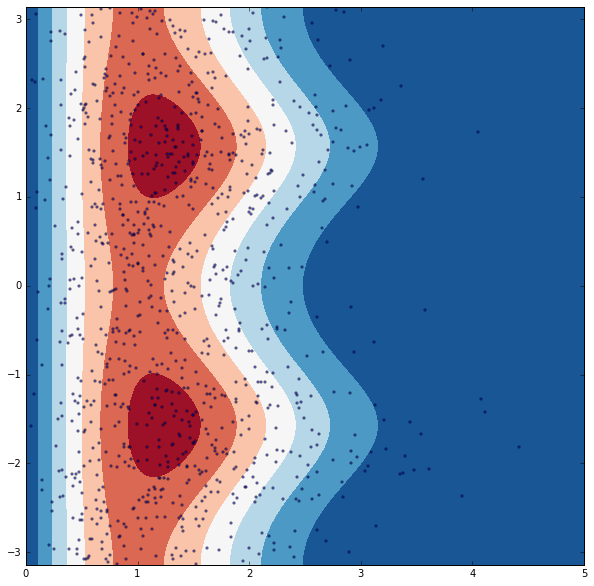

In [58]:
# Draw f_Y for polar coordinates
plt.figure()
plt.contourf(mesh_xx, mesh_yy, 
             f_Y(mesh).reshape(mesh_xx.shape), 
             cmap=plt.cm.RdBu_r)
samples = polar(samples)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, marker=".")
plt.xlim(0, 5)
plt.ylim(-np.pi, np.pi)
plt.plot()

# see http://kaharris.org/teaching/425/Lectures/lec30.pdf

# What if non-monotonic transformation?

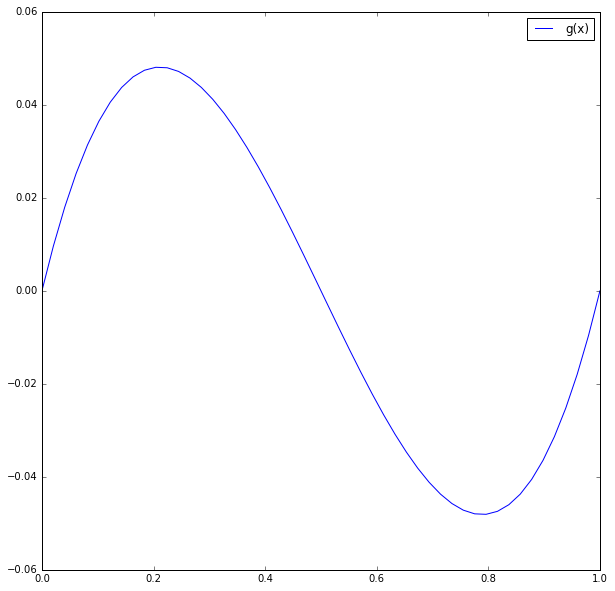

In [132]:
def _g(x):
    return x ** 3 - 1.5 * x ** 2 + x / 2

x = T.dvector("x")
g = theano.function([x], _g(x))
_dg, up = theano.scan(lambda x_i: T.grad(_g(x_i), x_i), sequences=x)
dg = theano.function([x], _dg)

reals = np.linspace(0, 1)
plt.plot(reals, g(reals), label="g(x)")
plt.legend()
plt.show()

/home/gilles/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:11: ComplexWarning: Casting complex values to real discards the imaginary part


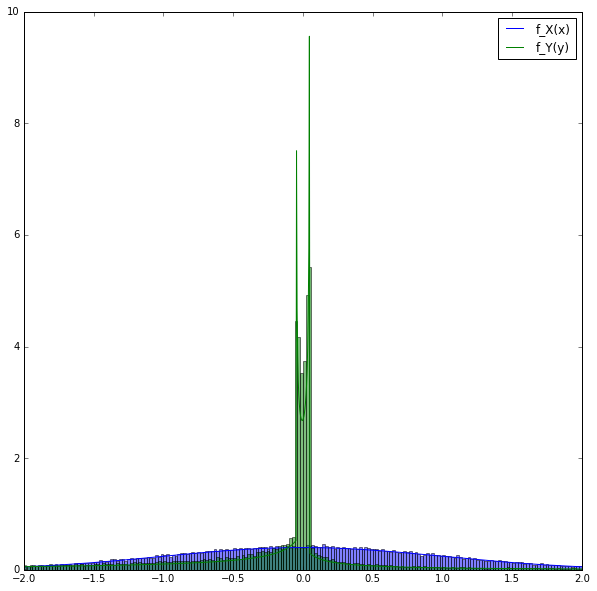

In [130]:
from scipy.stats import uniform, norm
#X = uniform()
X = norm()
f_X = X.pdf

def f_Y(y):
    r = []
    
    for y_i in y:
        x = np.roots([1, -1.5, 0.5, -y_i])  # Easy when g is a polynomial
        x = x[~np.iscomplex(x)].astype(float)
        r.append((1 / np.abs(dg(x)) * f_X(x)).sum())
        
    return np.array(r)
    

# Draw samples from X
samples = X.rvs(50000)

# Plot f_X
interval = (-2, 2)
reals = np.linspace(interval[0], interval[1], num=1000)
plt.hist(samples, normed=1, bins=200, range=interval, alpha=0.5, color="b")
plt.plot(reals, f_X(reals), label="f_X(x)", color="b")

# Plot f_Y
plt.hist(g(samples), normed=1, bins=200, range=interval, alpha=0.5, color="g")
plt.plot(reals, f_Y(reals), label="f_Y(y)", color="g")

plt.xlim(interval[0], interval[1])
plt.legend()
plt.show()

# What about change of variables induced by a classifier/regressor?